In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

Загружаем тренировочные данные

In [2]:
data = pd.read_csv('train.csv')

Смотрим на баланс классов

In [3]:
data.Default.value_counts()

0    2817
1     351
Name: Default, dtype: int64

Имеем дисбаланс классов. Учтём это при обучении моделей.

Посмотрим на описание числовых и категориальных признаков:

In [4]:
data.describe()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Default
count,3.168000e+03,535.000000,535.000000,535.000000,3154.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.0,3168.000000,3168.000000
mean,4.605727e+07,3.935514,-2.299065,5.267290,1.043754,13.350694,2.518939,-2.404356,8.462437,3.193813,-2.981692,5.0,36.411616,0.110795
std,5.370953e+07,0.888467,0.734579,0.498645,1.649416,8.851891,0.351308,2.474564,3.521127,2.048743,0.245540,0.0,10.821444,0.313928
min,5.856790e+05,2.500000,-3.000000,5.000000,0.000000,2.000000,2.500000,-3.000000,5.000000,2.500000,-3.000000,5.0,20.000000,0.000000
25%,2.761608e+07,3.500000,-3.000000,5.000000,0.000000,7.000000,2.500000,-3.000000,6.000000,2.500000,-3.000000,5.0,28.000000,0.000000
50%,4.349426e+07,3.500000,-2.000000,5.000000,0.000000,8.000000,2.500000,-3.000000,8.000000,2.500000,-3.000000,5.0,34.000000,0.000000
75%,5.778544e+07,4.500000,-2.000000,5.000000,2.000000,15.000000,2.500000,-3.000000,10.000000,2.500000,-3.000000,5.0,43.000000,0.000000
max,6.927701e+08,9.500000,2.000000,8.000000,17.000000,58.000000,17.500000,78.000000,29.000000,37.500000,4.000000,5.0,72.000000,1.000000


In [5]:
data.describe(include=[object])

,Deal_date,First_deal_date,First_default_date,Region,Gender
count,3168,3168,535,3161,3168
unique,486,545,68,8,2
top,2016-09-18,2015-10-10,2016-01-15,Tavern_district_3,Female
freq,23,21,57,1204,2729


Видим, что есть 4 признака с пропуском данных более 80%. Эти колонки потенциальные кандидаты на удаление. И один из признаков постоянен - его точно поже удалим.

# Вычисление IV и WoE
Подход для оценивания сигналов при задаче бинарной классификации называется Information Value (IV) / Weight of Evidence (WOE). Данный подход оценивает, на сколько весомы каждый из признаков для определения таргета.
Весь код был честно позаимствован на просторах сети.

In [6]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [7]:
print('WoE and IV for column:')
for col in data.columns:
    if col == 'Deal_id' or col == 'Default':
        continue
    else:
        print('{0:25}'.format(col), end='')
        d_f, iv = calculate_woe_iv(data, col, 'Default')
        print('{:.3f}'.format(iv))

WoE and IV for column:
Deal_date                0.651
First_deal_date          0.568
Secret_dwarf_info_1      0.122
Secret_dwarf_info_2      0.090
Secret_dwarf_info_3      0.046
First_default_date       0.378
Successful_deals_count   0.125
Region                   0.077
Tavern                   0.206
Hashed_deal_detail_1     0.000
Hashed_deal_detail_2     0.031
Hashed_deal_detail_3     0.139
Hashed_deal_detail_4     0.069
Hashed_deal_detail_5     0.015
Hashed_deal_detail_6     0.000
Age                      0.299
Gender                   0.048


# Подготавливаем данные

In [8]:
from datetime import datetime as dt

data['Deal_date'] = data['Deal_date'].astype('datetime64')
data['First_deal_date'] = data['First_deal_date'].astype('datetime64')
data['First_default_date'] = data['First_default_date'].astype('datetime64')

Сделаем новые признаки из колонок с датами: год, месяц, день:

In [9]:
data['Deal_date_year'] = data['Deal_date'].dt.year
data['Deal_date_month'] = data['Deal_date'].dt.month
data['Deal_date_day'] = data['Deal_date'].dt.day

data['First_deal_date_year'] = data['First_deal_date'].dt.year
data['First_deal_date_month'] = data['First_deal_date'].dt.month
data['First_deal_date_day'] = data['First_deal_date'].dt.day

data['First_default_date_year'] = data['First_default_date'].dt.year
data['First_default_date_month'] = data['First_default_date'].dt.month
data['First_default_date_day'] = data['First_default_date'].dt.day

Сделаем ещё признаки на основе разницы дат:

In [10]:
data['Days_1'] = data['Deal_date'] - data['First_deal_date']
data['Days_2'] = data['First_default_date'] - data['First_deal_date']

Заполним пропущенные даты такой датой, чтобы при переводе данных в timestamps получился 0:

In [11]:
data['First_default_date'] = data['First_default_date'].fillna(dt(1970, 1, 1))

Переведём все даты в timestamps и преобразуем их из секунд в дни (чтобы числа были не такими большими):

In [12]:
data['Deal_date'] = data['Deal_date'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)
data['First_deal_date'] = data['First_deal_date'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)
data['First_default_date'] = data['First_default_date'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)

Заполним пропуски в разнице в днях нулями:

In [13]:
from datetime import timedelta as td

data['Days_2'] = data['Days_2'].fillna(td(days=0))

Преобразуем timedelta в целое число и переведём из секунд в дни:

In [14]:
data['Days_1'] = data['Days_1'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)
data['Days_2'] = data['Days_2'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)

Так как пропусков в колонке Region мало, заполним их новой таргетной переменной:

In [15]:
data['Region'] = data['Region'].fillna('Tavern_district_8')

Все оставшиеся пропуски в таблице заполним нулями:

In [16]:
data = data.fillna(0)

Сделаем ещё несколко признаков.
Почему они сделаны таким образом - я их таким образом придумал, почему бы и нет, в этом нет ни какого смысла, просто новые признаки:

In [17]:
data['dwarf_Age'] = (data['Secret_dwarf_info_1'] + data['Secret_dwarf_info_2'] + data['Secret_dwarf_info_3']) * data['Age']

data['dwarf_Tavern'] = (data['Secret_dwarf_info_1'] + data['Secret_dwarf_info_2'] + data['Secret_dwarf_info_3']) * data['Tavern']

data['dwarf_deals'] = (data['Secret_dwarf_info_1'] + data['Secret_dwarf_info_2'] + data['Secret_dwarf_info_3']) * data['Successful_deals_count']

data['Tavern_Age'] = data['Tavern'] * data['Age']

Удаляем данные, которые не нужны по моему мнению:

In [18]:
data = data.drop(
    [
        'Deal_id',
        'Secret_dwarf_info_1',
        'Secret_dwarf_info_2',
        'Secret_dwarf_info_3',
        'First_default_date',
        'Hashed_deal_detail_6'
    ],
    axis=1
)

Посмотрим корреляцию оставшихся признаков между собой и с таргетом:

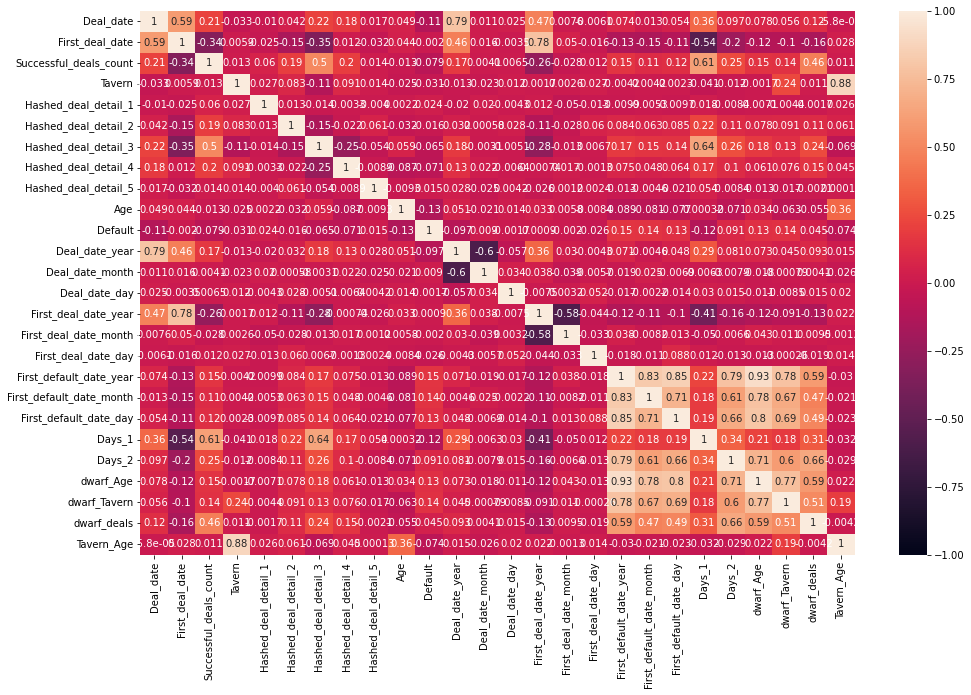

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure().set_size_inches(16, 10)

sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

Интересно, что есть некоторая корреляция созданных мною признаков между собой. Но с таргетом коррелируем только один изначальный.

# Посчитаем заново IV и WoE

In [20]:
print('WoE and IV for column:')
for col in data.columns:
    if col == 'Deal_id' or col == 'Default':
        continue
    else:
        print('{0:25}'.format(col), end='')
        d_f, iv = calculate_woe_iv(data, col, 'Default')
        print('{:.3f}'.format(iv))

WoE and IV for column:
Deal_date                0.651
First_deal_date          0.568
Successful_deals_count   0.126
Region                   0.081
Tavern                   0.206
Hashed_deal_detail_1     0.000
Hashed_deal_detail_2     0.031
Hashed_deal_detail_3     0.139
Hashed_deal_detail_4     0.069
Hashed_deal_detail_5     0.015
Age                      0.299
Gender                   0.048
Deal_date_year           0.085
Deal_date_month          0.120
Deal_date_day            0.101
First_deal_date_year     0.000
First_deal_date_month    0.055
First_deal_date_day      0.130
First_default_date_year  0.202
First_default_date_month 0.245
First_default_date_day   0.236
Days_1                   0.546
Days_2                   0.345
dwarf_Age                0.445
dwarf_Tavern             0.311
dwarf_deals              0.108
Tavern_Age               0.532


Вроде бы все признаки не бесполезны, кроме двух Hashed_deal_detail_1 и First_deal_date_year.
Я принял решение для обучения моделей оставить все признаки.

# Подготовка к обучению

In [21]:
X = data.drop(['Default'], axis=1)
Y = data['Default']

Выделяем числовые и категориальные признаки, а последние делим на две группы, которые будут кодировать признак разными способами: One-Hot (когда количество категорий не более 4) и кодирование по таргету (в остальных случаях):

In [22]:
numeric_columns = list(X.select_dtypes(exclude='object').columns)
categorical_columns = list(X.select_dtypes(include='object').columns)

columns_ohe = [x for x in categorical_columns if X[x].nunique() < 5]
columns_mte = [x for x in categorical_columns if X[x].nunique() >= 5]

numeric_columns_ind = [list(X.columns).index(col) for col in numeric_columns]
columns_ohe_ind = [list(X.columns).index(col) for col in columns_ohe]
columns_mte_ind = [list(X.columns).index(col) for col in columns_mte]

Создаём трансформер, который будет обрабатывать наши колонки:

In [23]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders.one_hot import OneHotEncoder

transformer = [
    ('StandardScaler', StandardScaler(), numeric_columns_ind),
    ('OneHotEncoder', OneHotEncoder(), columns_ohe_ind),
    ('MeanTargetEncoder', TargetEncoder(), columns_mte_ind)
]

columns_transformer = ColumnTransformer(transformers=transformer)

Делим данные на тренировочные и тестовые, учитывая что у нас есть большой дисбаланс классов, деление производим учитывая это.

Так же создадим делитель нашей тренировочной выборки на фолды для обучение на кроссвалидации. StratifiedKFold выбран по ричине дисбаланса классов, он как раз призван делить на фолды с учётом имеющегося дисбаланса.

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.125,
    #random_state=9,
    stratify=Y
)

splitter = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)

# Тренеруем 8 моделей
Тренеруем модели с подбором параметров в каждой из них. При обучении и подборе параметров в качестве оптимизируемого (максимизируемого) параметра используем roc_auc. Проверку качества обучения и подбора параметров модели осуществляем на части выше отобранных данных.

### 1. Тренеруем LogisticRegression

In [25]:
%%time

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

model_1 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', LogisticRegression(class_weight={0: 313/352, 1: 39/352},
                                                 random_state=9))])

param_grid_1 ={
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

search_1 = GridSearchCV(
    model_1,
    param_grid_1,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_1.fit(X_train, Y_train)

print(f"Лучшие параметры {search_1.best_params_}")
print()

train_preds_1 = search_1.predict(X_train)
train_accuracy_1 = accuracy_score(Y_train, train_preds_1)

test_preds_1 = search_1.predict(X_test)
test_accuracy_1 = accuracy_score(Y_test, test_preds_1)

print(f"Качество на тренировочной выборке составило {train_accuracy_1}")
print(f"Качество на тестовой выборке составило {test_accuracy_1}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_1.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_1.predict_proba(X_test)[:, 1])}")

Лучшие параметры {'model__C': 10, 'model__penalty': 'l2'}

Качество на тренировочной выборке составило 0.8892496392496393
Качество на тестовой выборке составило 0.8888888888888888

ROC-AUC тренировочной выборки 0.7535662136358532
ROC-AUC тестовой выборки 0.8013946280991735
CPU times: total: 1.23 s
Wall time: 5.8 s


### 2. Тренеруем RandomForestClassifier

In [26]:
%%time

from sklearn.ensemble import RandomForestClassifier

model_2 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', RandomForestClassifier(class_weight={0: 313/352, 1: 39/352},
                                                     random_state=9,
                                                     n_jobs=-1))])

param_grid_2 ={
    'model__n_estimators': [25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'model__max_depth': [5, 6, 7, 8, 9, 10, None],
    'model__max_features': ['sqrt', 'log2', None]
}

search_2 = GridSearchCV(
    model_2,
    param_grid_2,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_2.fit(X_train, Y_train)

print(f"Лучшие параметры {search_2.best_params_}")
print()

train_preds_2 = search_2.predict(X_train)
train_accuracy_2 = accuracy_score(Y_train, train_preds_2)

test_preds_2 = search_2.predict(X_test)
test_accuracy_2 = accuracy_score(Y_test, test_preds_2)

print(f"Качество на тренировочной выборке составило {train_accuracy_2}")
print(f"Качество на тестовой выборке составило {test_accuracy_2}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_2.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_2.predict_proba(X_test)[:, 1])}")

Лучшие параметры {'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__n_estimators': 500}

Качество на тренировочной выборке составило 0.8914141414141414
Качество на тестовой выборке составило 0.8888888888888888

ROC-AUC тренировочной выборки 0.910593256734346
ROC-AUC тестовой выборки 0.8218620867768596
CPU times: total: 8.83 s
Wall time: 4min 24s


### 3. Тренеруем GradientBoostingClassifier

In [27]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

model_3 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', GradientBoostingClassifier(random_state=9))])

param_grid_3 ={
    'model__loss': ['log_loss', 'deviance', 'exponential'],
    'model__learning_rate': [0.001, 0.01, 0.1, 1],
    'model__criterion': ['friedman_mse', 'squared_error', 'mse'],
    'model__max_depth': [3, 4, 5],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

search_3 = GridSearchCV(
    model_3,
    param_grid_3,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_3.fit(X_train, Y_train)

print(f"Лучшие параметры {search_3.best_params_}")
print()

train_preds_3 = search_3.predict(X_train)
train_accuracy_3 = accuracy_score(Y_train, train_preds_3)

test_preds_3 = search_3.predict(X_test)
test_accuracy_3 = accuracy_score(Y_test, test_preds_3)

print(f"Качество на тренировочной выборке составило {train_accuracy_3}")
print(f"Качество на тестовой выборке составило {test_accuracy_3}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_3.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_3.predict_proba(X_test)[:, 1])}")

Лучшие параметры {'model__criterion': 'squared_error', 'model__learning_rate': 0.01, 'model__loss': 'log_loss', 'model__max_depth': 5, 'model__max_features': 'log2'}

Качество на тренировочной выборке составило 0.8906926406926406
Качество на тестовой выборке составило 0.8888888888888888

ROC-AUC тренировочной выборки 0.8714346122589213
ROC-AUC тестовой выборки 0.8153409090909091
CPU times: total: 11.1 s
Wall time: 1min 51s


### 4. Тренеруем KNeighborsClassifier

In [28]:
%%time

from sklearn.neighbors import KNeighborsClassifier

def gaussian_kernel_001(distances, h=0.01):
        return np.exp(- distances**2 / h**2)

def gaussian_kernel_01(distances, h=0.1):
        return np.exp(- distances**2 / h**2)

def gaussian_kernel_05(distances, h=0.5):
        return np.exp(- distances**2 / h**2)

def gaussian_kernel_1(distances, h=1):
        return np.exp(- distances**2 / h**2)

def gaussian_kernel_2(distances, h=2):
        return np.exp(- distances**2 / h**2)

def gaussian_kernel_3(distances, h=3):
        return np.exp(- distances**2 / h**2)

model_4 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', KNeighborsClassifier(n_jobs=-1))])

param_grid_4 ={
    'model__n_neighbors': [i for i in range(5, 105, 5)],
    'model__weights': ['uniform',
                       'distance',
                       gaussian_kernel_001,
                       gaussian_kernel_01,
                       gaussian_kernel_05,
                       gaussian_kernel_1,
                       gaussian_kernel_2,
                       gaussian_kernel_3],
    'model__p': [2, 1]
}

search_4 = GridSearchCV(
    model_4,
    param_grid_4,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_4.fit(X_train, Y_train)

print(f"Лучшие параметры {search_4.best_params_}")
print()

train_preds_4 = search_4.predict(X_train)
train_accuracy_4 = accuracy_score(Y_train, train_preds_4)

test_preds_4 = search_4.predict(X_test)
test_accuracy_4 = accuracy_score(Y_test, test_preds_4)

print(f"Качество на тренировочной выборке составило {train_accuracy_4}")
print(f"Качество на тестовой выборке составило {test_accuracy_4}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_4.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_4.predict_proba(X_test)[:, 1])}")

Лучшие параметры {'model__n_neighbors': 60, 'model__p': 1, 'model__weights': 'distance'}

Качество на тренировочной выборке составило 1.0
Качество на тестовой выборке составило 0.8914141414141414

ROC-AUC тренировочной выборки 1.0
ROC-AUC тестовой выборки 0.7704028925619835
CPU times: total: 12 s
Wall time: 23.2 s


### 5. Тренеруем svm.SVC

In [29]:
%%time

from sklearn.svm import SVC

model_5 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', SVC(probability=True,
                                  class_weight={0: 313/352, 1: 39/352},
                                  random_state=9))])
param_grid_5 ={
    'model__C': [i for i in range(1, 11)],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

search_5 = GridSearchCV(
    model_5,
    param_grid_5,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_5.fit(X_train, Y_train)

print(f"Лучшие параметры {search_5.best_params_}")
print()

train_preds_5 = search_5.predict(X_train)
train_accuracy_5 = accuracy_score(Y_train, train_preds_5)

test_preds_5 = search_5.predict(X_test)
test_accuracy_5 = accuracy_score(Y_test, test_preds_5)

print(f"Качество на тренировочной выборке составило {train_accuracy_5}")
print(f"Качество на тестовой выборке составило {test_accuracy_5}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_5.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_5.predict_proba(X_test)[:, 1])}")

Лучшие параметры {'model__C': 2, 'model__kernel': 'rbf'}

Качество на тренировочной выборке составило 0.8892496392496393
Качество на тестовой выборке составило 0.8888888888888888

ROC-AUC тренировочной выборки 0.9173563438629411
ROC-AUC тестовой выборки 0.6251936983471074
CPU times: total: 3.92 s
Wall time: 37.9 s


### 6. Тренеруем CatBoostClassifier

In [30]:
%%time

from catboost import CatBoostClassifier

model_6 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', CatBoostClassifier(loss_function='MultiClass',
                                                 thread_count=100,
                                                 early_stopping_rounds=10,
                                                 random_state=9))])

param_grid_6 ={
    'model__iterations': [10, 100, 500, 1000, 1500, 2000]
}

search_6 = GridSearchCV(
    model_6,
    param_grid_6,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_6.fit(X_train, Y_train)

print(f"Лучшие параметры {search_6.best_params_}")
print()

train_preds_6 = search_6.predict(X_train)
train_accuracy_6 = accuracy_score(Y_train, train_preds_6)

test_preds_6 = search_6.predict(X_test)
test_accuracy_6 = accuracy_score(Y_test, test_preds_6)

print(f"Качество на тренировочной выборке составило {train_accuracy_6}")
print(f"Качество на тестовой выборке составило {test_accuracy_6}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_6.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_6.predict_proba(X_test)[:, 1])}")

Learning rate set to 0.5
0:	learn: 0.4632692	total: 150ms	remaining: 1.35s
1:	learn: 0.3801051	total: 153ms	remaining: 612ms
2:	learn: 0.3419995	total: 156ms	remaining: 364ms
3:	learn: 0.3242180	total: 158ms	remaining: 238ms
4:	learn: 0.3136266	total: 161ms	remaining: 161ms
5:	learn: 0.3057528	total: 164ms	remaining: 109ms
6:	learn: 0.2959436	total: 167ms	remaining: 71.6ms
7:	learn: 0.2918943	total: 170ms	remaining: 42.5ms
8:	learn: 0.2870325	total: 173ms	remaining: 19.2ms
9:	learn: 0.2827195	total: 176ms	remaining: 0us
Лучшие параметры {'model__iterations': 10}

Качество на тренировочной выборке составило 0.8921356421356421
Качество на тестовой выборке составило 0.8838383838383839

ROC-AUC тренировочной выборки 0.8090967354031358
ROC-AUC тестовой выборки 0.8351949896694215
CPU times: total: 656 ms
Wall time: 52 s


### 7. Тренируем LGBMClassifier

In [31]:
%%time

from lightgbm import LGBMClassifier

model_7 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', LGBMClassifier())])

param_grid_7 ={
    'model__n_estimators': [i for i in range(50, 350, 50)],
    'model__max_depth': [i for i in range(1, 11)],
    'model__learning_rate': [0.1, 0.01, 0.001]
}

search_7 = GridSearchCV(
    model_7,
    param_grid_7,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_7.fit(X_train, Y_train)

print(f"Лучшие параметры {search_7.best_params_}")
print()

train_preds_7 = search_7.predict(X_train)
train_accuracy_7 = accuracy_score(Y_train, train_preds_7)

test_preds_7 = search_7.predict(X_test)
test_accuracy_7 = accuracy_score(Y_test, test_preds_7)

print(f"Качество на тренировочной выборке составило {train_accuracy_7}")
print(f"Качество на тестовой выборке составило {test_accuracy_7}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_7.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_7.predict_proba(X_test)[:, 1])}")

Лучшие параметры {'model__learning_rate': 0.1, 'model__max_depth': 1, 'model__n_estimators': 200}

Качество на тренировочной выборке составило 0.8914141414141414
Качество на тестовой выборке составило 0.8914141414141414

ROC-AUC тренировочной выборки 0.8030088998420889
ROC-AUC тестовой выборки 0.7979403409090909
CPU times: total: 8.03 s
Wall time: 29.6 s


### 8. Тренируем XGBClassifier

In [32]:
%%time

from xgboost import XGBClassifier

model_8 = Pipeline([('columns_transformer', columns_transformer),
                    ('model', XGBClassifier(seed=9, eval_metric='auc'))])

param_grid_8 ={
    'model__booster': ['gbtree', 'gblinear'],
    'model__learning_rate': [1, 0.1, 0.01, 0.001],
    'model__max_depth': [i for i in range(1, 11)]
}

search_8 = GridSearchCV(
    model_8,
    param_grid_8,
    cv=splitter,
    scoring='roc_auc',
    n_jobs=-1
)

search_8.fit(X_train, Y_train)

print(f"Лучшие параметры {search_8.best_params_}")
print()

train_preds_8 = search_8.predict(X_train)
train_accuracy_8 = accuracy_score(Y_train, train_preds_8)

test_preds_8 = search_8.predict(X_test)
test_accuracy_8 = accuracy_score(Y_test, test_preds_8)

print(f"Качество на тренировочной выборке составило {train_accuracy_8}")
print(f"Качество на тестовой выборке составило {test_accuracy_8}")
print()
print(f"ROC-AUC тренировочной выборки {roc_auc_score(Y_train, search_8.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC тестовой выборки {roc_auc_score(Y_test, search_8.predict_proba(X_test)[:, 1])}")

Лучшие параметры {'model__booster': 'gbtree', 'model__learning_rate': 0.1, 'model__max_depth': 1}

Качество на тренировочной выборке составило 0.8892496392496393
Качество на тестовой выборке составило 0.8888888888888888

ROC-AUC тренировочной выборки 0.7838084981268707
ROC-AUC тестовой выборки 0.8091102789256198
CPU times: total: 4.66 s
Wall time: 18 s
Parser   : 172 ms


# Данные для предсказания

In [33]:
pred = pd.read_csv('test.csv')

Посмотрим на описание числовых и категориальных признаков:

In [34]:
pred.describe()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age
count,9.890000e+02,140.000000,140.000000,140.000000,988.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.0,989.000000
mean,7.736690e+07,3.978571,-2.142857,5.328571,1.632591,13.298281,2.517189,-2.402427,9.695652,3.464611,-2.976744,5.0,37.040445
std,6.747813e+07,0.948060,0.861415,0.515136,2.494499,12.702410,0.251931,2.836259,4.492390,2.660964,0.247385,0.0,10.866338
min,6.958071e+06,3.500000,-3.000000,5.000000,0.000000,7.000000,2.500000,-3.000000,5.000000,2.500000,-3.000000,5.0,20.000000
25%,7.240788e+07,3.500000,-3.000000,5.000000,0.000000,7.000000,2.500000,-3.000000,6.000000,2.500000,-3.000000,5.0,29.000000
50%,7.700465e+07,3.500000,-2.000000,5.000000,1.000000,7.000000,2.500000,-3.000000,8.000000,2.500000,-3.000000,5.0,35.000000
75%,8.238742e+07,4.500000,-2.000000,6.000000,2.000000,13.000000,2.500000,-3.000000,12.000000,2.500000,-3.000000,5.0,43.000000
max,8.652261e+08,8.500000,2.000000,7.000000,32.000000,81.000000,8.500000,33.000000,38.000000,25.500000,2.000000,5.0,76.000000


In [35]:
pred.describe(include=[object])

,Deal_date,First_deal_date,First_default_date,Region,Gender
count,989,989,140,985,989
unique,96,452,55,8,2
top,2016-10-15,2016-03-02,2016-05-14,Tavern_district_3,Female
freq,31,8,8,391,841


Картина очень похожая на данные из тренировки.

Делаем заготовки таблиц для отеветов по каждой модели, а так же коллективное голосование моделей Hard Vote (максимально предсказание из 8 моделей) и Soft Vote (среднее предсказание из 8 моделей).

In [36]:
prediction_1 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_2 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_3 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_4 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_5 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_6 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_7 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_8 = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_max = pd.DataFrame({'Deal_id': pred.Deal_id})
prediction_mean = pd.DataFrame({'Deal_id': pred.Deal_id})

Далее обрабатываем и выделяем признаки точно так же, как это делали с тренеровочными данными:

In [37]:
pred['Deal_date'] = pred['Deal_date'].astype('datetime64')
pred['First_deal_date'] = pred['First_deal_date'].astype('datetime64')
pred['First_default_date'] = pred['First_default_date'].astype('datetime64')

In [38]:
pred['Deal_date_year'] = pred['Deal_date'].dt.year
pred['Deal_date_month'] = pred['Deal_date'].dt.month
pred['Deal_date_day'] = pred['Deal_date'].dt.day

pred['First_deal_date_year'] = pred['First_deal_date'].dt.year
pred['First_deal_date_month'] = pred['First_deal_date'].dt.month
pred['First_deal_date_day'] = pred['First_deal_date'].dt.day

pred['First_default_date_year'] = pred['First_default_date'].dt.year
pred['First_default_date_month'] = pred['First_default_date'].dt.month
pred['First_default_date_day'] = pred['First_default_date'].dt.day

In [39]:
pred['Days_1'] = pred['Deal_date'] - pred['First_deal_date']
pred['Days_2'] = pred['First_default_date'] - pred['First_deal_date']

In [40]:
pred['First_default_date'] = pred['First_default_date'].fillna(dt(1970, 1, 1))

In [41]:
pred['Deal_date'] = pred['Deal_date'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)
pred['First_deal_date'] = pred['First_deal_date'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)
pred['First_default_date'] = pred['First_default_date'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)

In [42]:
pred['Days_2'] = pred['Days_2'].fillna(td(days=0))

In [43]:
pred['Days_1'] = pred['Days_1'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)
pred['Days_2'] = pred['Days_2'].astype(np.int64) // 10 ** 9 // (60 * 60 * 24)

In [44]:
pred['dwarf_Age'] = (pred['Secret_dwarf_info_1'] + pred['Secret_dwarf_info_2'] + pred['Secret_dwarf_info_3']) * pred['Age']

pred['dwarf_Tavern'] = (pred['Secret_dwarf_info_1'] + pred['Secret_dwarf_info_2'] + pred['Secret_dwarf_info_3']) * pred['Tavern']

pred['dwarf_deals'] = (pred['Secret_dwarf_info_1'] + pred['Secret_dwarf_info_2'] + pred['Secret_dwarf_info_3']) * pred['Successful_deals_count']

pred['Region'] = pred['Region'].fillna('Tavern_district_8')

In [45]:
pred = pred.fillna(0)

In [46]:
pred['Tavern_Age'] = pred['Tavern'] * data['Age']

In [47]:
pred = pred.drop(
    [
        'Deal_id', 'Secret_dwarf_info_1', 'Secret_dwarf_info_2',
        'Secret_dwarf_info_3', 'First_default_date', 'Hashed_deal_detail_6'
    ],
    axis=1
)

# Делаем предсказания
В качестве ответа от нас ожидается не предсказание класса, а вероятность наступления класса 1, поэтому применяем метод predict_proba к тестовым данным и берём вторую колонку.

Предсказание каждой модели (и коллективные) сохраняем в отделный файл, для сдачи на проверку.

Сумму считал лично для себя (зачем, объяснить сложно).

### 1. Предсказание LogisticRegression

In [48]:
prediction_1['Prediction'] = search_1.predict_proba(pred)[:, 1]

prediction_1.to_csv('prediction_1.csv', index=False)

prediction_1.Prediction.sum()

8.381285680353976

### 2. Предсказание RandomForestClassifier

In [49]:
prediction_2['Prediction'] = search_2.predict_proba(pred)[:, 1]

prediction_2.to_csv('prediction_2.csv', index=False)

prediction_2.Prediction.sum()

63.4112666944623

### 3. Предсказание GradientBoostingClassifier

In [50]:
prediction_3['Prediction'] = search_3.predict_proba(pred)[:, 1]

prediction_3.to_csv('prediction_3.csv', index=False)

prediction_3.Prediction.sum()

101.59761541271833

### 4. Предсказание KNeighborsClassifier

In [51]:
prediction_4['Prediction'] = search_4.predict_proba(pred)[:, 1]

prediction_4.to_csv('prediction_4.csv', index=False)

prediction_4.Prediction.sum()

85.19274758670429

### 5. Предсказание svm.SVC

In [52]:
prediction_5['Prediction'] = search_5.predict_proba(pred)[:, 1]

prediction_5.to_csv('prediction_5.csv', index=False)

prediction_5.Prediction.sum()

109.9416844101779

### 6. Предсказание CatBoostClassifier

In [53]:
prediction_6['Prediction'] = search_6.predict_proba(pred)[:, 1]

prediction_6.to_csv('prediction_6.csv', index=False)

prediction_6.Prediction.sum()

95.9552801859371

### 7. Предсказание LGBMClassifier

In [54]:
prediction_7['Prediction'] = search_7.predict_proba(pred)[:, 1]

prediction_7.to_csv('prediction_7.csv', index=False)

prediction_7.Prediction.sum()

58.265357725250965

### 8. Предсказание XGBClassifier

In [55]:
prediction_8['Prediction'] = search_8.predict_proba(pred)[:, 1]

prediction_8.to_csv('prediction_8.csv', index=False)

prediction_8.Prediction.sum()

84.78485

### 9. Hard vote

In [56]:
prediction_max['Prediction_1'] = prediction_1['Prediction']
prediction_max['Prediction_2'] = prediction_2['Prediction']
prediction_max['Prediction_3'] = prediction_3['Prediction']
prediction_max['Prediction_4'] = prediction_4['Prediction']
prediction_max['Prediction_5'] = prediction_5['Prediction']
prediction_max['Prediction_6'] = prediction_6['Prediction']
prediction_max['Prediction_7'] = prediction_7['Prediction']
prediction_max['Prediction_8'] = prediction_8['Prediction']

prediction_max['Prediction'] = prediction_max[
    [
        'Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4',
        'Prediction_5', 'Prediction_6', 'Prediction_7', 'Prediction_8'
    ]
].max(axis=1)
prediction_max.drop(
    [
        'Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4',
        'Prediction_5', 'Prediction_6', 'Prediction_7', 'Prediction_8'
    ],
    axis=1,
    inplace=True
)

prediction_max.to_csv('prediction_max.csv', index=False)

prediction_max.Prediction.sum()

144.21418483468614

### 10. Soft vote

In [57]:
prediction_mean['Prediction_1'] = prediction_1['Prediction']
prediction_mean['Prediction_2'] = prediction_2['Prediction']
prediction_mean['Prediction_3'] = prediction_3['Prediction']
prediction_mean['Prediction_4'] = prediction_4['Prediction']
prediction_mean['Prediction_5'] = prediction_5['Prediction']
prediction_mean['Prediction_6'] = prediction_6['Prediction']
prediction_mean['Prediction_7'] = prediction_7['Prediction']
prediction_mean['Prediction_8'] = prediction_8['Prediction']

prediction_mean['Prediction'] = prediction_mean[
    [
        'Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4',
        'Prediction_5', 'Prediction_6', 'Prediction_7', 'Prediction_8'
    ]
].mean(axis=1)
prediction_mean.drop(
    [
        'Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4',
        'Prediction_5', 'Prediction_6', 'Prediction_7', 'Prediction_8'
    ],
    axis=1,
    inplace=True
)

prediction_mean.to_csv('prediction_mean.csv', index=False)

prediction_mean.Prediction.sum()

75.94126080053303

# Итоги

Напомню, что от нас хотели получить качества на тестовых данных не менее 0.7.

Как видно из процесса обучения и проверки 7 из 8 обученных моделей преодолевают данный bassline.

На практике же всё оказалось с точностью до наоборот. Лишь одна модель svm.SVC, которая при обучении показала чсебя хуже всех, смогла преодолеть bassline. Ну и коллективное голосование по схеме Soft Vote.

Всё дело здесь заключается в том, что признаки по классово на тренировочных и на тестовых данных сильно различаются. В связи с этим качество предсказания моделей не достаточное.

Так же мною скорее всего были совершены следующие ошибки в обработки данных:
1. признаки кандидаты на удаление следовало оставить;
2. заполнение нулями пропусков, следовало заполнять средним в числовых колонках и самым частым в категориальных;
3. колонку с пропуском дат нужно было заполнить какой-то очень отдалённой датой в будущем (сделать выброс);
4. не совсем понятно, нужны ли были фичи, полученные из сложения и перемножения признаков (качество моих моделей они увеличивали);
5. неплохо было бы всю обработку признаков свести в функции, чтобы не копипастить код.

По итогу простой RandomForestClassifier способен справиться с данной задачей.

Есть ещё один способ решения задачи: глубокий анализ данных и отбора небольшого количества признаков для обучения. В таком случае с поставленной задачай справляется даже LogisticRegression.